## Imports

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp

## Load Data
- Variable: 2m dewpoint temperature ('d2m'), 2m temperature ('t2m'), Snowfall ('sf'), Total precipitation ('tp')
- Year: 2019
- Months: All
- Day: 15
- Time: 1:00-23:00
- Sub-region extraction: North 85°, West -170°, South 40°, East -50°

In [2]:
# Prepare model re-analysis data
ds_final = pd.read_csv('Datasets/ERA5_Land_processed.csv')

In [3]:
ds_final.set_index(['latitude', 'longitude', 'time'], inplace=True)

## Multiple Linear Regression

In [4]:
import statsmodels.formula.api as smf
# ds_ = ds_final[(ds_final['t2m'] <= x1_t2m) & (ds_final['t2m'] >= x0_t2m)]
reg = smf.ols(formula='snow_frac ~ t2m + d2m', data=ds_final).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              snow_frac   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 1.043e+07
Date:                Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:26:50   Log-Likelihood:            -1.0603e+06
No. Observations:             9925001   AIC:                         2.121e+06
Df Residuals:                 9924998   BIC:                         2.121e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4497      0.000   3563.443      0.000       0.449       0.450
t2m           -0.0170   3.95e-05   -429.813      0.000      -0.017      -0.017
d2m           -0.0209      4e-05   -523.702      0.000      -0.021      -0.021
==============================================================================
Omnibus:                  1750832.675   Durbin-Watson:                   0.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           474228.021
Skew:                           0.259   Prob(JB):                         0.00
Kurtosis:                       2.063   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Fitted vs Residuals Plot')

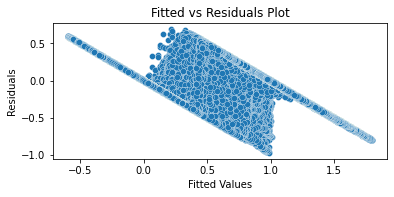

In [11]:
pred = reg.fittedvalues.copy()
true = ds_final['snow_frac'].values.copy()
residual = true - pred

fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred, residual, marker='o', edgecolor='white', linewidth=0.3)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title("Fitted vs Residuals Plot")

Coefficient of Determination: 0.9665435976669289


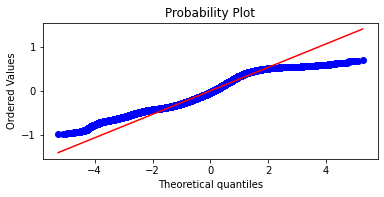

In [12]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
print("Coefficient of Determination:", r**2)

Text(0, 0.5, 'Residuals')

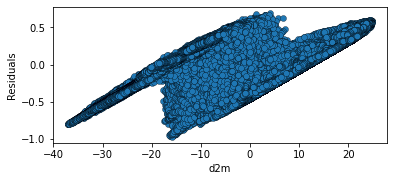

In [13]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(ds_final['d2m'], residual, marker='o', edgecolor='white', linewidth=0.3)
plt.xlabel('d2m')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

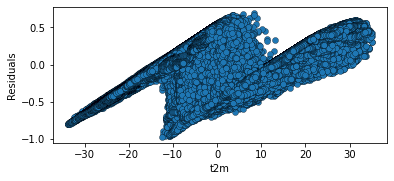

In [14]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(ds_final['t2m'], residual, marker='o', edgecolor='white', linewidth=0.3)
plt.xlabel('t2m')
plt.ylabel('Residuals')

## K-Means Clustering

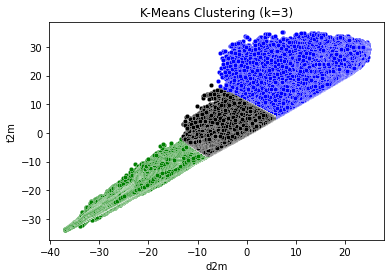

In [5]:
from sklearn.cluster import KMeans

data = ds_final[['d2m', 't2m']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

#predictions from kmeans
kmeans_pred = kmeans.predict(data)
kmeans_frame = pd.DataFrame(data)
kmeans_frame['cluster'] = kmeans_pred
kmeans_frame.columns = ['d2m', 't2m', 'cluster']

#plotting results
color=['blue','green','black']
for k in range(3):
    data = kmeans_frame[kmeans_frame["cluster"]==k]
    plt.scatter(data["d2m"],data["t2m"], c=color[k], marker='o', edgecolor='white', linewidth=0.3, s=20)
plt.title('K-Means Clustering (k=3)')
plt.xlabel('d2m')
plt.ylabel('t2m')
plt.show()

## Gaussian Mixture Model

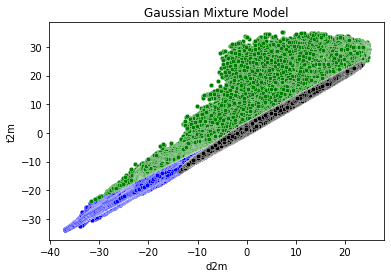

In [6]:
from sklearn.mixture import GaussianMixture

data = ds_final[['d2m', 't2m']]
gmm = GaussianMixture(n_components=3)
gmm.fit(data)

#predictions from gmm
gmm_labels = gmm.predict(data)
gmm_frame = pd.DataFrame(data)
gmm_frame['cluster'] = gmm_labels
gmm_frame.columns = ['d2m', 't2m', 'cluster']

color=['blue','green','black']
for k in range(3):
    data = gmm_frame[gmm_frame["cluster"]==k]
    plt.scatter(data["d2m"],data["t2m"],c=color[k], marker='o', edgecolor='white', linewidth=0.3, s=20)
plt.title("Gaussian Mixture Model")
plt.xlabel('d2m')
plt.ylabel('t2m')
plt.show()

In [ ]:
# look at clustering metrics
# - can use "no ground truth metrics"
# - compare w/ 5%-95% thresholds 

## Classification

In [4]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

def cm_plot(y_true, y_pred, classes, cm_fig_path,
                normalize=False,
                title=None,
                cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    samples = np.array(y_true).shape[0]
    accuracy = np.trace(cm) / float(np.sum(cm)) * 100
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # print('for i {} and j {} : {}'.format(i, j, cm[i,j]))
            ax.annotate(format(cm[i, j], fmt), (j, i),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
    np.set_printoptions(precision=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\naccuracy={:0.2f}%; N={}'.format(accuracy, samples))
    plt.ylim([2.5, -.5])
    plt.tight_layout()
#     plt.savefig(cm_fig_path)
    plt.show()
    plt.close('all')

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer

def Standardize(X, y, method="robust"):
    if method == "robust":
        X_norm = RobustScaler().fit_transform(np.array(X))
    elif method == "standard":
        X_norm = StandardScaler().fit_transform(np.array(X))
    elif method == "power":
        X_norm = PowerTransformer().fit_transform(np.array(X))
    y_encoded = LabelEncoder().fit_transform(y)
    return X_norm, y_encoded

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

def Train_and_Evaluate_Classifier(X, y_encoded, y, classifier='sgd', normalize=None, kernel='linear', ccp_alpha=0.015, max_depth=30, min_samples_leaf=0.05, min_samples_split=0.05):
    if classifier == 'sgd':
        clf = SGDClassifier(class_weight="balanced", early_stopping=True, n_iter_no_change=10)
        title = "SGD Classifier"
    elif classifier == 'svm':
        if kernel == 'linear':
            clf = LinearSVC(dual=False, class_weight='balanced')
            title = "LinearSVM Classifier"
        else:
            clf = SVC(kernel=kernel, class_weight='balanced', max_iter=10000)
            title = str(kernel + " SVM Classifier")
    elif classifier == 'nb':
        clf = GaussianNB()
#         clf.partial_fit(X, y_encoded, classes=np.unique(y_encoded))
        title = "Naive Bayes Classifier"
    elif classifier == 'gp':
        clf = GaussianProcessClassifier(copy_X_train=False)
        title = 'Gaussian Process Classifier'
    elif classifier == "decision_tree":
        clf = DecisionTreeClassifier(
            class_weight='balanced', 
            ccp_alpha=ccp_alpha, 
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth, 
            min_samples_split=min_samples_split
        )
        title = "Decision Tree Classifier"
    elif classifier == "random_forest":
        clf = RandomForestClassifier(
            n_jobs=-1, 
            class_weight="balanced_subsample",
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=ccp_alpha
        )
        title = "Random Forest Classifier"
    clf.fit(X, y_encoded)
    y_pred = clf.predict(X)           
    pred = [round(value) for value in y_pred]
    print("Classifier Accuracy %.2f%%" % (balanced_accuracy_score(y_encoded, pred) * 100.0))
    print('------------------------------------------------------------------------')
    print(classification_report(y_encoded, pred, target_names=list(np.unique(y))))
    cm_plot(y_encoded, y_pred, list(np.unique(y)), normalize=normalize, cm_fig_path='cm.png', title=title)
    return clf, y_pred

In [7]:
def Decision_Plot(clf, X_norm, y_encoded, y, title, save_title, n_classes=3, plot_colors='rwb', plot_step=0.1, plot_hyperplane=False):

    x_min, x_max = X_norm[:, 0].min() - 1, X_norm[:, 0].max() + 1
    y_min, y_max = X_norm[:, 1].min() - 1, X_norm[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

#     if hasattr(clf, "predict_proba"):
#         Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#     else:
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    plt.xlabel('Dewpoint Temperature ($^\circ$C)')
    plt.ylabel('Air Temperature ($^\circ$C)')

    # Plot the training points
    
    for i, color in zip(reversed(range(n_classes)), plot_colors):
        idx = np.where(y_encoded == i)
        plt.scatter(X_norm[idx, 0], X_norm[idx, 1], c=color, label=np.unique(y)[i],
                    cmap=plt.cm.coolwarm, edgecolor='k', s=20)
        ## you can do an if condition or zorder-> dictionary

    plt.suptitle(title)
    plt.legend(loc='lower right')
    plt.axis("tight")
   
    if plot_hyperplane is True and hasattr(clf, "coef_") and hasattr(clf, "intercept_"):
        # Plot the three one-against-all classifiers
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        coef = clf.coef_
        intercept = clf.intercept_

        def plot_hyperplane(c, color):
            def line(x0):
                return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

            plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                     ls="--", color=color)

        for i, color in zip(reversed(clf.classes_), plot_colors):
            plot_hyperplane(i, color)
    plt.savefig(save_title)
    plt.show()

In [8]:
def Precip_Type(x, lower_thresh, upper_thresh):
    if x <= lower_thresh:
        return "Rain"
    elif x > lower_thresh and x <= upper_thresh:
        return "Mixed"
    else:
        return "Snow"
ds_final['precip_type'] = [Precip_Type(x, 0.05, 0.95) for x in ds_final['snow_frac']]
ds_final

d2m        t2m  snow_frac  \
latitude  longitude  time                                                   
83.099998 -74.500000 2019-06-15 01:00:00   2.114648   3.919733        0.0   
                     2019-06-15 02:00:00   1.984857   3.654993        0.0   
                     2019-06-15 03:00:00   1.870691   3.457117        0.0   
                     2019-06-15 04:00:00   1.768518   3.289911        0.0   
                     2019-06-15 05:00:00   1.733667   3.231378        0.0   
...                                             ...        ...        ...   
40.000000 -74.099998 2019-09-15 09:00:00  20.209894  21.283319        0.0   
                     2019-09-15 10:00:00  20.312036  21.121698        0.0   
                     2019-09-15 11:00:00  20.346887  21.035303        0.0   
                     2019-09-15 12:00:00  20.421411  21.085474        0.0   
                     2019-09-15 13:00:00  20.517572  21.638666        0.0   

                                         precip_type  
latitude  longitude  time                             
83.099998 -74.500000 2019-06-15 01:00:00        Rain  
                     2019-06-15 02:00:00        Rain  
                     2019-06-15 03:00:00        Rain  
                     2019-06-15 04:00:00        Rain  
                     2019-06-15 05:00:00        Rain  
...                                              ...  
40.000000 -74.099998 2019-09-15 09:00:00        Rain  
                     2019-09-15 10:00:00        Rain  
                     2019-09-15 11:00:00        Rain  
                     2019-09-15 12:00:00        Rain  
                     2019-09-15 13:00:00        Rain  

[9925001 rows x 4 columns]

In [9]:
ds_final['precip_type'].value_counts()

Rain     5334596
Snow     3597332
Mixed     993073
Name: precip_type, dtype: int64

<AxesSubplot:>

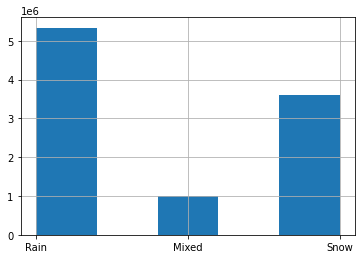

In [10]:
ds_final['precip_type'].hist(bins=5)

In [11]:
y = ds_final['precip_type']
X = ds_final.drop(['precip_type', 'snow_frac'], axis=1)

X_norm, y_encoded = Standardize(X, y)

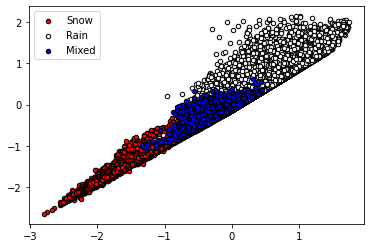

In [26]:
for i, color in zip(reversed(range(3)), 'rwb'):
    idx = np.where(y_encoded[::100] == i)
    plt.scatter(X_norm[::100][idx, 0][::100], X_norm[::100][idx, 1], c=color, label=np.unique(y)[i],
                cmap=plt.cm.coolwarm, edgecolor='k', s=20)
plt.legend()
    ## you can do an if condition or zorder-> dictionary

## SGD

Classifier Accuracy 67.17%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.77      0.03      0.07    993073
        Rain       0.92      0.98      0.95   5334596
        Snow       0.86      1.00      0.92   3597332

    accuracy                           0.89   9925001
   macro avg       0.85      0.67      0.65   9925001
weighted avg       0.88      0.89      0.85   9925001



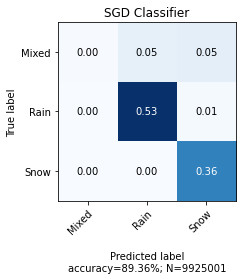

In [31]:
sgd, sgd_pred = Train_and_Evaluate_Classifier(X_norm, y_encoded, y, normalize='all')

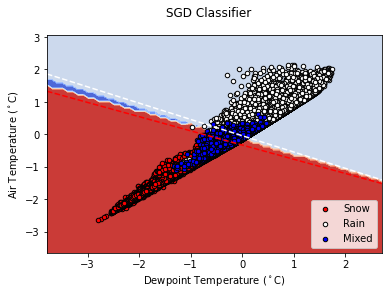

In [36]:
Decision_Plot(sgd, X_norm[::100], y_encoded[::100], y[::100], "SGD Classifier", 'sgd_test.png', plot_hyperplane=True)

## Linear SVC

Classifier Accuracy 75.31%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.71      0.30      0.42    993073
        Rain       0.94      0.98      0.96   5334596
        Snow       0.90      0.98      0.94   3597332

    accuracy                           0.91   9925001
   macro avg       0.85      0.75      0.77   9925001
weighted avg       0.90      0.91      0.90   9925001



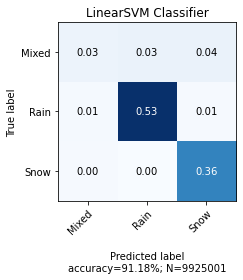

In [33]:
linsvm, linsvm_pred = Train_and_Evaluate_Classifier(X_norm, y_encoded, y, classifier='svm', normalize='all', kernel='linear')

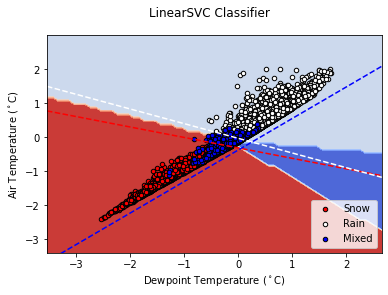

In [37]:
Decision_Plot(linsvm, X_norm[::1000], y_encoded[::1000], y[::1000], "LinearSVC Classifier", 'linsvc_test.png', plot_hyperplane=True)

Classifier Accuracy 85.93%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.43      0.82      0.57       997
        Rain       0.99      0.88      0.93      5381
        Snow       0.96      0.88      0.92      3548

    accuracy                           0.87      9926
   macro avg       0.79      0.86      0.81      9926
weighted avg       0.92      0.87      0.89      9926



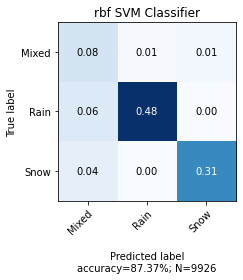

In [38]:
rbfsvm, rbfsvm_pred = Train_and_Evaluate_Classifier(X_norm[::1000], y_encoded[::1000], y[::1000], classifier='svm', normalize='all', kernel='rbf')

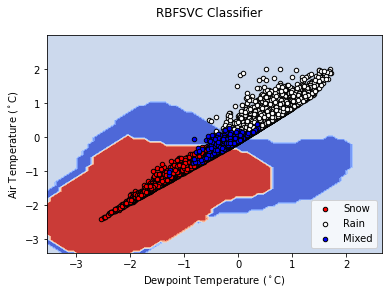

In [39]:
Decision_Plot(rbfsvm, X_norm[::1000], y_encoded[::1000], y[::1000], "RBFSVC Classifier", 'rbfsvc_test.png', plot_hyperplane=True)

Classifier Accuracy 79.81%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.27      0.95      0.42       997
        Rain       1.00      0.70      0.82      5381
        Snow       0.98      0.74      0.85      3548

    accuracy                           0.74      9926
   macro avg       0.75      0.80      0.70      9926
weighted avg       0.92      0.74      0.79      9926



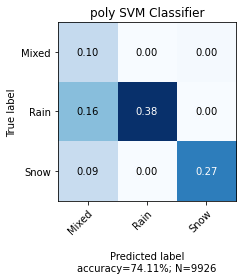

In [40]:
polysvm, polysvm_pred = Train_and_Evaluate_Classifier(X_norm[::1000], y_encoded[::1000], y[::1000], classifier='svm', normalize='all', kernel='poly')

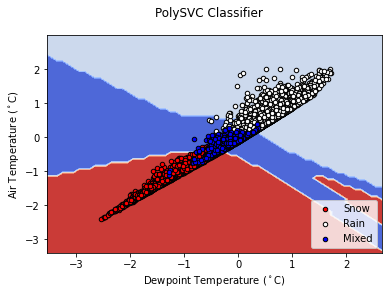

In [41]:
Decision_Plot(polysvm, X_norm[::1000], y_encoded[::1000], y[::1000], "PolySVC Classifier", 'polysvc_test.png', plot_hyperplane=True)

## Discretized LinearSVC

In [26]:
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=50, encode='onehot')
X_binned = enc.fit_transform(X_norm)

In [27]:
linsvm_binned, linsvm_pred_binned = Train_and_Evaluate_Classifier(X_binned, y_encoded, y, classifier='svm', normalize='all', kernel='linear')

Classifier Accuracy 85.32%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.56      0.68      0.62    993073
        Rain       0.98      0.94      0.96   5334596
        Snow       0.94      0.94      0.94   3597332

    accuracy                           0.91   9925001
   macro avg       0.83      0.85      0.84   9925001
weighted avg       0.92      0.91      0.92   9925001



In [65]:
h=0.1
# create the grid for background colors
x_min, x_max = X_norm[:, 0].min() - .5, X_norm[:, 0].max() + .5
y_min, y_max = X_norm[:, 1].min() - .5, X_norm[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
enc.fit(X_norm)
grid_encoded = enc.transform(np.c_[xx.ravel(), yy.ravel()])
Z = linsvm_binned.decision_function(grid_encoded)

# horizontal = grid_encoded[:, 0].reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=.5)

TypeError: Shapes of x (60, 56) and z (3360, 3) do not match

In [49]:
Decision_Plot(linsvm_binned, X_norm[::100], y_encoded[::100], y[::100], "Discretized LinearSVC Classifier", 'linsvc_discrete.png')

ValueError: X has 2 features per sample; expecting 100

<Figure size 432x288 with 0 Axes>

## Naive Bayes

In [42]:
nb, nb_pred = Train_and_Evaluate_Classifier(X_norm, y_encoded, y, classifier='nb', normalize='all')

Classifier Accuracy 85.45%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.40      0.88      0.55    993073
        Rain       0.99      0.88      0.93   5334596
        Snow       0.97      0.80      0.88   3597332

    accuracy                           0.85   9925001
   macro avg       0.79      0.85      0.79   9925001
weighted avg       0.92      0.85      0.88   9925001



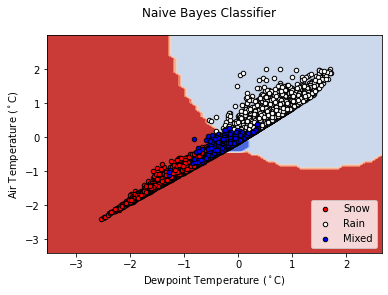

In [43]:
Decision_Plot(nb, X_norm[::1000], y_encoded[::1000], y[::1000], "Naive Bayes Classifier", 'nb_test.png')

## Decision Tree

Classifier Accuracy 86.22%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.44      0.82      0.58    993073
        Rain       0.99      0.89      0.94   5334596
        Snow       0.96      0.87      0.91   3597332

    accuracy                           0.88   9925001
   macro avg       0.80      0.86      0.81   9925001
weighted avg       0.92      0.88      0.89   9925001



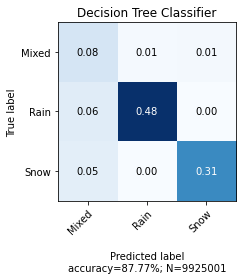

In [45]:
dt, dt_pred = Train_and_Evaluate_Classifier(
    X_norm, 
    y_encoded, 
    y, 
    classifier='decision_tree', 
    normalize='all', 
    ccp_alpha=2e-2,
    min_samples_leaf=0.01,
    min_samples_split=0.05,
    max_depth=3
)

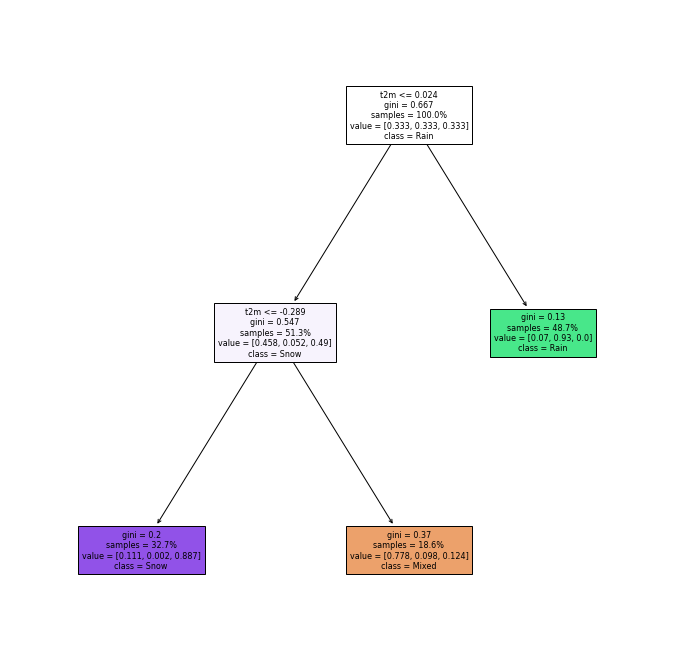

In [46]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(dt, feature_names=['d2m', 't2m'], class_names=list(np.unique(y)), filled=True, proportion=True, fontsize=8)
plt.savefig('dt_splits_full.png')

In [47]:
Decision_Plot(dt, X_norm[::100], y_encoded[::100], y[::100], "Decision Tree Classifier", 'dt_test.png')

## Random Forests

In [ ]:
rf, rf_pred = Train_and_Evaluate_Classifier(
    X_norm, 
    y_encoded, 
    y, 
    classifier='random_forest', 
    normalize='all',
    ccp_alpha=1e-2,
    min_samples_leaf=0.05,
    max_depth=3
)

In [ ]:
# Done with smaller subset of data
Decision_Plot(rf, X_norm[::1000], y_encoded[::1000], y[::1000], "Random Forest Classifier", 'rf_test.png')

## Decision Tree Tests

In [74]:
# clfs = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, class_weight='balanced')
#     clf.fit(X_norm[::1000], y_encoded[::1000])
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [75]:
# scores = [clf.score(X_norm[::1000], y_encoded[::1000]) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha")
# ax.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post")
# plt.show()

In [68]:
dt_smaller, dt_pred_smaller = Train_and_Evaluate_Classifier(
    X_norm[::1000], 
    y_encoded[::1000], 
    y[::1000], 
    classifier='decision_tree', 
    normalize='all', 
    ccp_alpha=0, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None
)

Classifier Accuracy 100.00%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       1.00      1.00      1.00       997
        Rain       1.00      1.00      1.00      5381
        Snow       1.00      1.00      1.00      3548

    accuracy                           1.00      9926
   macro avg       1.00      1.00      1.00      9926
weighted avg       1.00      1.00      1.00      9926



In [71]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(dt_smaller, feature_names=['d2m', 't2m'], class_names=list(np.unique(y)), filled=True)
plt.savefig('dt_splits.png')

## Regression

In [21]:
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def Train_and_Evaluate_Regressor(X, y, regressor='sgd'):
    if regressor == 'sgd':
        reg = SGDRegressor(early_stopping=True, n_iter_no_change=10)
        reg.fit(X, y)
        title = "SGD Regressor"
    elif regressor == 'svm':
        reg = LinearSVR(loss='squared_epsilon_insensitive', dual=False)
        reg.fit(X, y)
        title = "LinearSVM Regressor"
    elif regressor == "decision_tree":
        reg = DecisionTreeRegressor()
        reg.fit(X, y)
        title = "Decision Tree Regressor"
    # make predictions for test data
    y_pred = reg.predict(X) 
    print(title)
    print('------------------------------------------------')
    print("R2 Score:", r2_score(y, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y, y_pred))
    print("Mean Squared Error:", mean_squared_error(y, y_pred))
    return reg

In [17]:
yy = ds_final['snow_frac']

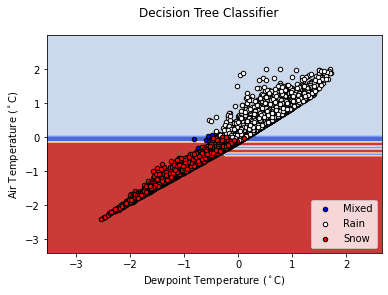

In [72]:
Decision_Plot(dt_smaller, X_norm[::1000], y_encoded[::1000], y[::100], "Decision Tree Classifier", 'dt_test.png')

In [22]:
sgd_reg = Train_and_Evaluate_Regressor(X_norm, yy, regressor='sgd')

SGD Regressor
------------------------------------------------
R2 Score: 0.6775240544353917
Mean Absolute Error: 0.22709448710929248
Mean Squared Error: 0.07250916115298929


In [23]:
svr = Train_and_Evaluate_Regressor(X_norm, yy, regressor='svm')

LinearSVM Regressor
------------------------------------------------
R2 Score: 0.6775787536943285
Mean Absolute Error: 0.22739147182540173
Mean Squared Error: 0.07249686194917035


In [24]:
dt_reg = Train_and_Evaluate_Regressor(X_norm, yy, regressor='decision_tree')

Decision Tree Regressor
------------------------------------------------
R2 Score: 0.9923297309208563
Mean Absolute Error: 0.006074036323431576
Mean Squared Error: 0.0017246705820884033
